In [2]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# import OpenCV
import cv2

In [3]:
template_color = cv2.imread('../Data/28_AP_0.14.tif') # Read template image
template_color = cv2.cvtColor(template_color, cv2.COLOR_BGR2RGB) # Convert to RGB
template = cv2.cvtColor(template_color, cv2.COLOR_BGR2GRAY) # Color to Grayscale

In [4]:
# Image plotting function
def plot_image(image, gray=True):
    plt.figure(figsize=(10,7))
    if gray:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image)
    plt.grid('on')
    plt.show()

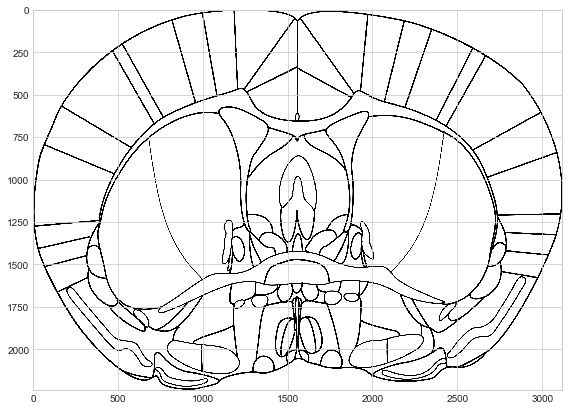

In [5]:
# Plot template image
plot_image(template)

In [6]:
# Invert template color to highlight the edges
template_inv = cv2.bitwise_not(template)

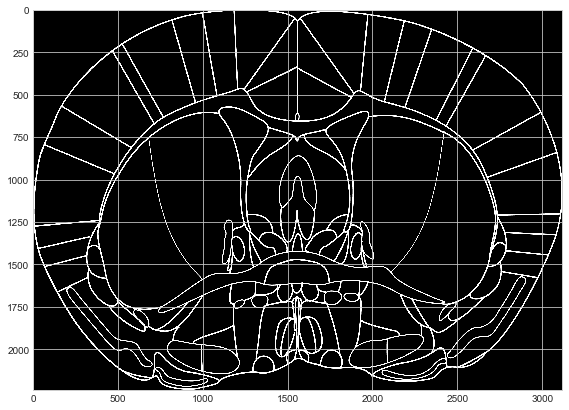

In [7]:
plot_image(template_inv)

In [8]:
img = cv2.imread('../Data/20170914_D2CreAi14_M527_G_RB_pDMS_S1P2_R1C3_001.tif') # Read base image
# Reduce image size (downsample) for 
height, width, depth = img.shape
img_down = cv2.resize(img,(int(0.1*width), int(0.1*height)), interpolation = cv2.INTER_AREA)
height_down, width_down, depth_down = img_down.shape
# img_color = cv2.imread('../Data/20170913_D2CreAi14_M529_G_RB_pDMS_S1P2_R1C4_001.tif') # Read base image
img_gray = cv2.cvtColor(img_down, cv2.COLOR_BGR2RGB) # Convert BGR (OpenCV) to RGB (matplotlib) for plotting
img_gray = cv2.cvtColor(img_gray, cv2.COLOR_RGB2GRAY) # Convert to grayscale
img_inverse = cv2.bitwise_not(img_gray)

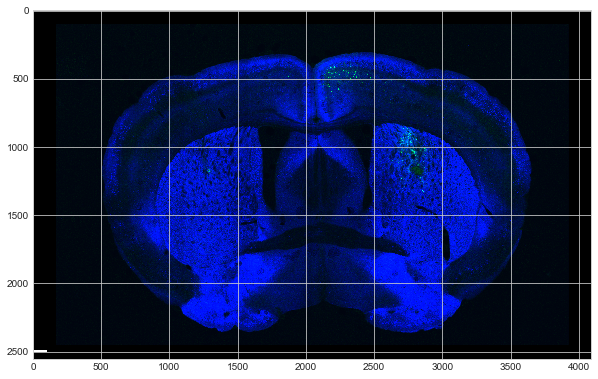

In [9]:
# Plot base image
plot_image(img)

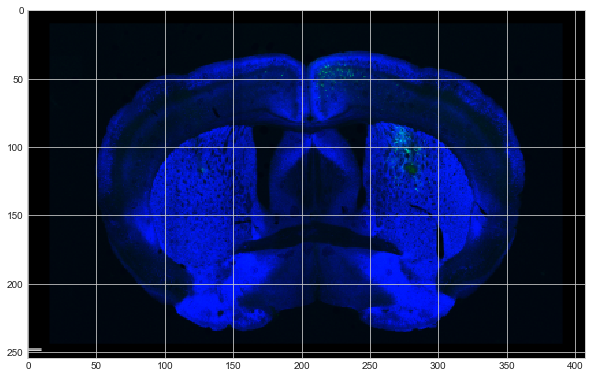

In [10]:
# Plot shrinked image
plot_image(img_down)

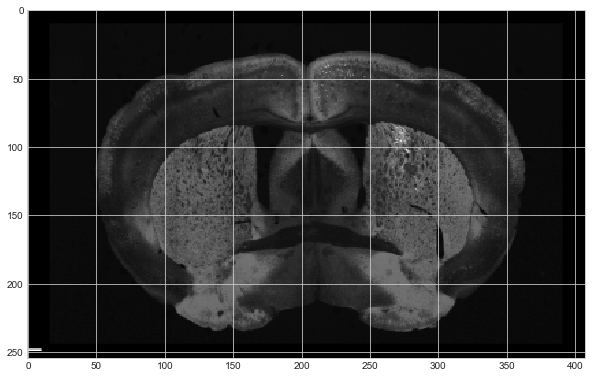

In [11]:
# Plot grayscale image
plot_image(img_gray)

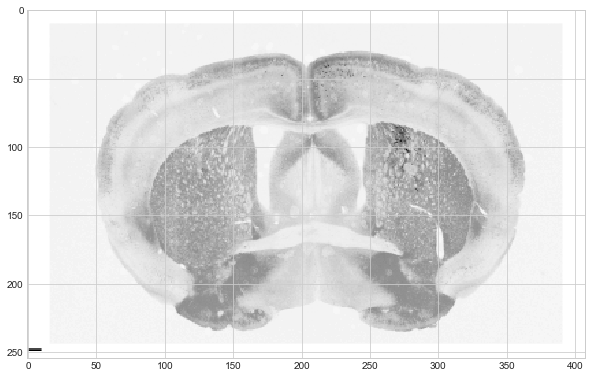

In [12]:
plot_image(img_inverse)

## Edge detection

In [13]:
# Morphological transforms for filling empty spaces in stained image
kernel = np.ones((3,3),np.uint8)
# img_down = cv2.bilateralFilter(img_down,9,17,17)
img_gray = cv2.dilate(img_gray, kernel, iterations = 3)
img_gray = cv2.erode(img_gray, kernel, iterations = 5)
img_inverse = cv2.dilate(img_inverse, kernel, iterations = 3)
img_inverse = cv2.erode(img_inverse, kernel, iterations = 5)

In [14]:
# Extract edges using Canny edge detector (pixel-wise edge detector)
edges = cv2.Canny(img_gray,20,100)
edges_inverse = cv2.Canny(img_inverse,10,50)
edges_sobel = cv2.Sobel(img_inverse, -1,1,0,ksize=5)
edges_sobel = edges_sobel[:,25:410]

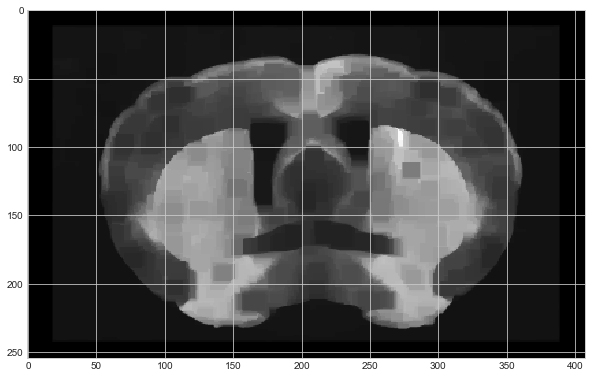

In [15]:
plot_image(img_gray)
# Don't forget to run the cells from the beginning so you're not just layering this operation

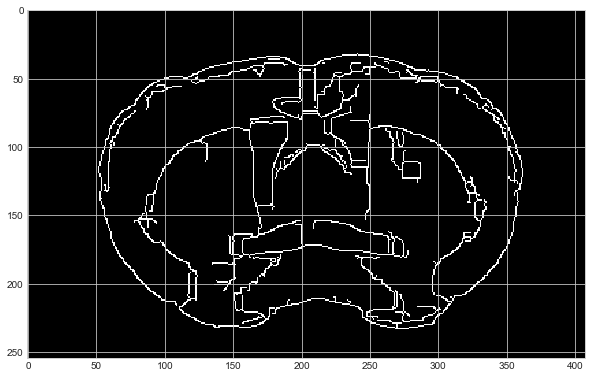

In [16]:
plot_image(edges)

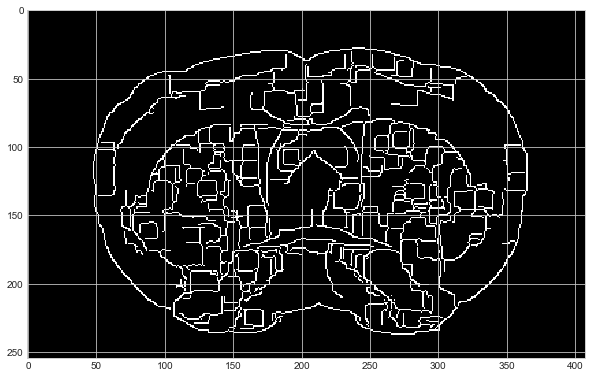

In [17]:
plot_image(edges_inverse)

### Splitting Hemispheres

In [18]:
current_max = [0,150]
max_dev = 0
max_dev_point = []
current_dev = []
for x in range(150,250):
    line_max = 150
    y = 0
    while(edges_inverse[y,x] == 0): # don't forget it's a matrix you idiot
        y += 1
    if(y < current_max[1]):
        current_max = [x,y]
    elif((y - current_max[1]) > max_dev):
        max_dev = y - current_max[1]
        max_dev_point = [x,y]
print(current_max)
print(max_dev_point)

[238, 28]
[203, 37]


In [24]:
# Redefining color image for easy changes
img_down = cv2.resize(img,(int(0.1*width), int(0.1*height)), interpolation = cv2.INTER_AREA)
# Use Hough Tranform to find vertical lines
lines = cv2.HoughLinesP(edges_inverse, .01, np.pi, 10, minLineLength=10)
# Draw lines on colored image for reference
for l in lines:
    cv2.line(img_down, (l[0][0],l[0][1]),(l[0][2],l[0][3]), (255,0,0),1)

# Collect lines which define the midline of the brain
midpoints = []
for l in lines:
    if(np.abs(l[0][0]-max_dev_point[0]) <= 5):
        midpoints.append((l[0][0],l[0][1]))
        midpoints.append((l[0][2],l[0][3]))

print(midpoints)
#img_down = cv2.resize(img,(int(0.1*width), int(0.1*height)), interpolation = cv2.INTER_AREA)

#for i in range(1,len(midpoints)-1):
 #   cv2.line(img_down, midpoints[i-1], midpoints[i], (255,0,0))

[(208, 158), (208, 146), (204, 66), (204, 54), (203, 51), (203, 41)]


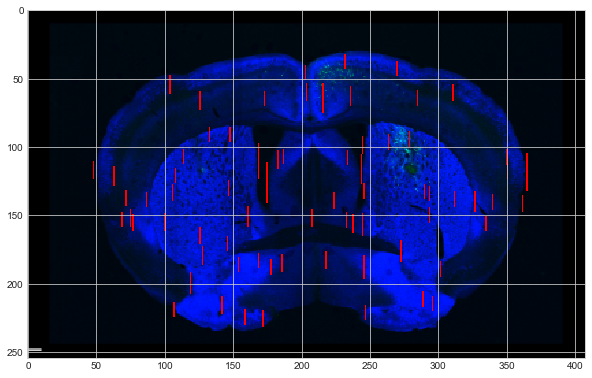

In [20]:
plot_image(img_down, gray=False)

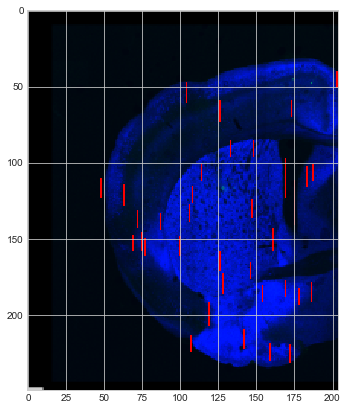

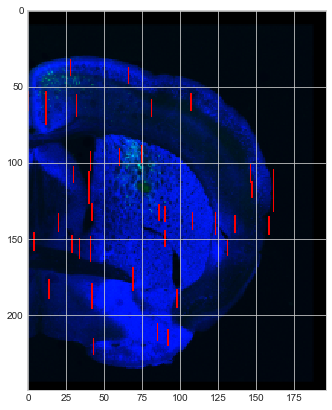

In [37]:
#from scipy.interpolate import interp1d
#img = cv2.imread('../Data/20170914_D2CreAi14_M527_G_RB_pDMS_S1P2_R1C3_001.tif', 0) # Read base image
#keep points together, sort by x,y element
#midline = interp1d(x_points, y_points, kind='cubic')
pt = midpoints[int(len(midpoints)/2)]
img_left = img_down[0:250,0:pt[0]]
img_right = img_down[0:250,pt[0]:400]
plot_image(img_left)
plot_image(img_right)

In [689]:
# Check fit
# out = edges | img
# plot_image(out)

## Stage 1: Regions of Interest

In [22]:
from skimage.feature import match_template

In [23]:
im2, contours, hierarchy = cv2.findContours(template_inv, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [24]:
template_inv_color = cv2.bitwise_not(template_color)

In [25]:
cnt = contours[4]
cv2.drawContours(template_inv_color, contours, 0, (0,255,0), 5);

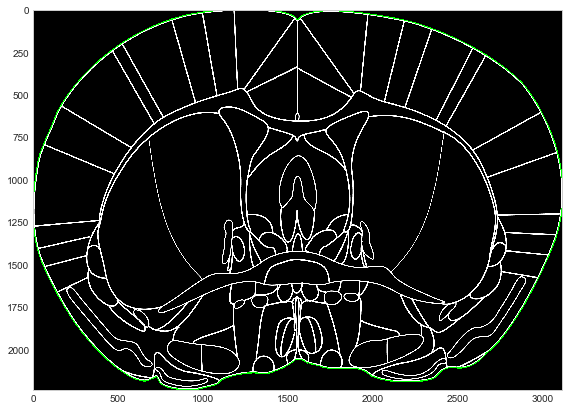

In [26]:
plot_image(template_inv_color, gray=False)

In [27]:
outer_edge = np.zeros_like(template_inv)

In [28]:
cv2.drawContours(outer_edge, contours, 0, (255,255,255), 7);

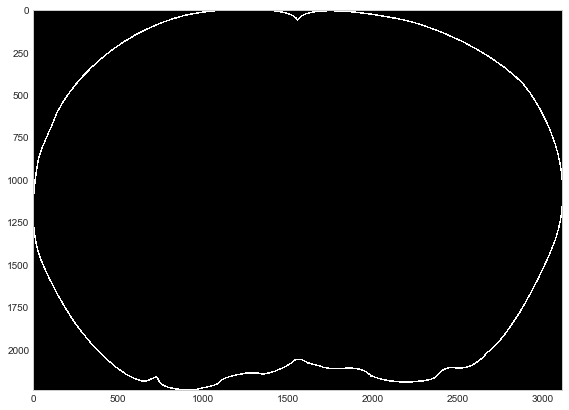

In [29]:
plot_image(outer_edge)

In [30]:
height, width = outer_edge.shape
outer_edge_down = cv2.resize(outer_edge,(int(0.1*width), int(0.1*height)), interpolation = cv2.INTER_AREA)

In [31]:
# Fitting the outer edge
result = match_template(edges, outer_edge_down)

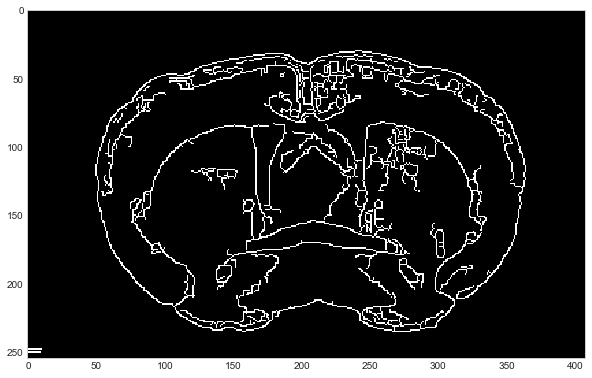

In [32]:
plot_image(edges)

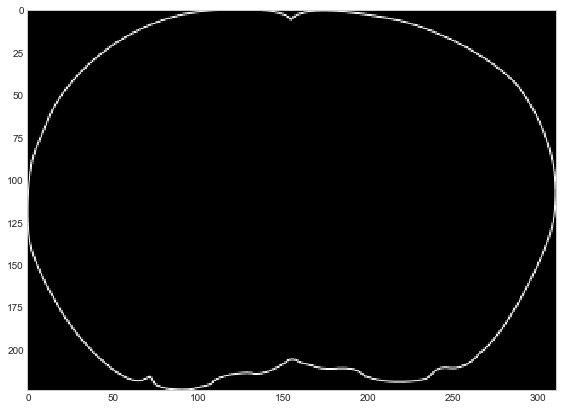

In [33]:
plot_image(outer_edge_down)

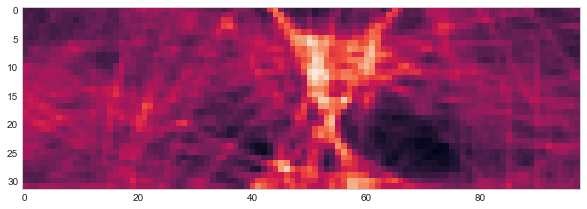

In [68]:
plot_image(result, gray=False)

In [35]:
print('result shape: {}'.format(result.shape))

result shape: (32, 98)


In [36]:
print('template outer edge shape: {}'.format(outer_edge_down.shape))

template outer edge shape: (224, 311)


In [37]:
# outer_edge_down = cv2.resize(outer_edge_down,None,fx=s, fy=s, interpolation = cv2.INTER_CUBIC)

In [38]:
print('base image outer edge shape: {}'.format(edges.shape))

base image outer edge shape: (255, 408)


In [39]:
# Normalize the result
result_norm = (result - np.mean(result))/np.std(result)

In [40]:
# Find the Region of Interests for Stage 2
_,ROI = cv2.threshold(result_norm,2,255,cv2.THRESH_BINARY)

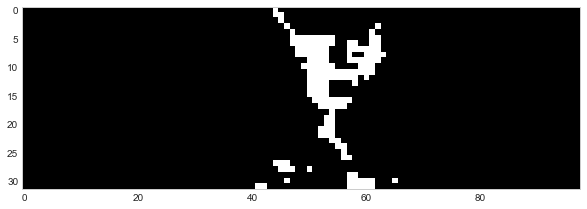

In [41]:
plot_image(ROI)

## Stage 2: Multiresolution Matching

In [42]:
# Find nearest edge pixel
def find_nearest_edge(img, TARGET):
    nonzero = cv2.findNonZero(img)
    distances = (nonzero[:,:,0] - TARGET[0]) ** 2 + (nonzero[:,:,1] - TARGET[1]) ** 2
    nearest_index = np.argmin(distances)
    return nonzero[nearest_index]

# Distance EPF
def find_distance_epf(img, rho):
    epf = np.zeros((img.shape[0], img.shape[1]))
    for x in range(img.shape[1]):
        for y in range(img.shape[0]):
            # Check more efficient solution - KD tree?
            coords = find_nearest_edge(img, (x,y))
            epf[y][x] = -np.exp(-rho*((coords[0][0] - x)**2 + (coords[0][1] - y)**2)**0.5)
    return epf

In [43]:
dist_epf = find_distance_epf(edges, 0.01)

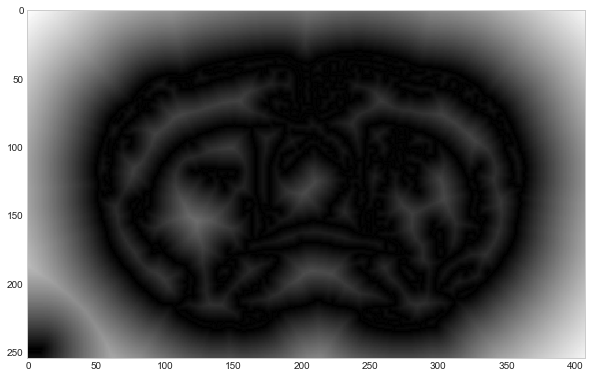

In [44]:
plot_image(dist_epf)

In [45]:
# Apply horizontal and vertical derivatives using Sobel operators
# Then find the orientation EPF
def find_angle_epf(img):
    sobelx64f = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
    abs_sobelx64f = np.absolute(sobelx64f)
    
    sobely64f = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)
    abs_sobely64f = np.absolute(sobely64f)

    angle_epf = np.arctan2(abs_sobely64f, abs_sobelx64f)
    return angle_epf

In [46]:
# Orientation EPF of the base image (with edges)
angle_epf = find_angle_epf(edges)

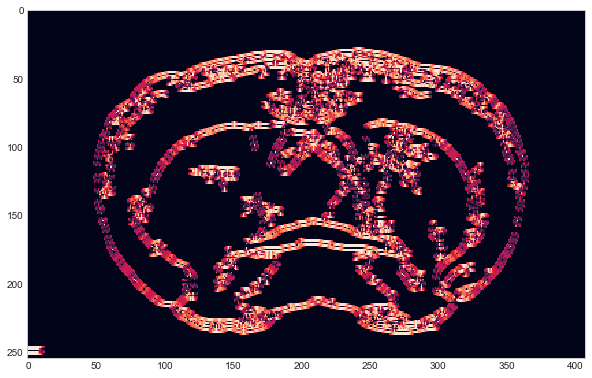

In [47]:
plot_image(angle_epf, gray=False)

In [48]:
# Orientation EPF of the template
angle_epf_template = find_angle_epf(outer_edge_down)

In [49]:
outer_edge_down.shape

(224, 311)

### Coarse resolution matching

In [50]:
# rotations = [i*2*np.pi/12 for i in range(12)]
rotations = [0] # For testing
# translations_x = [int(outer_edge_down.shape[1]*i/4) for i in range(4)] # Horizontal translatins
# translations_y = [int(outer_edge_down.shape[0]*i/4) for i in range(4)] # Vertical translations
translations_x = [0]
translations_y = [0]
scales = [0.7, 0.8, 0.9, 1.0]
# threshold = 0.07

In [51]:
# get coordinates in the ROI with bright pixel values
nz = np.nonzero(ROI)

In [52]:
# get the candidate pixels to place the template from ROI
candidates = []
for i in range(len(nz[0])):
    px = [nz[0][i], nz[1][i]]
    candidates.append(px)

In [53]:
def search_best_match(candidates, translations_x, translations_y, scales, rotations, outer_edge_down, dist_epf, angle_epf):
    coarse_res = {}
    for pixel in candidates:
        for ty in translations_y:
            for tx in translations_x:
                for s in scales:
                    for r in rotations:
                        # resize the template
                        outer_edge_down_rz = cv2.resize(outer_edge_down,None,fx=s, fy=s, interpolation = cv2.INTER_CUBIC)
                        angle_epf_template = find_angle_epf(outer_edge_down_rz)
                        EPF = 0.0
                        for x in range(outer_edge_down_rz.shape[0]):
                            for y in range(outer_edge_down_rz.shape[1]):
                                # Calculate the modified EPF and store the results in a dictionary
                                EPF += 1 + (dist_epf[pixel[0] + x + tx, pixel[1] + y + ty])*np.absolute(np.cos(angle_epf[pixel[0] + x + tx, pixel[1] + y + ty] - angle_epf_template[x, y]))
                        EPF = EPF/(outer_edge_down_rz.shape[0]*outer_edge_down_rz.shape[1])
                        coarse_res[(pixel[0], pixel[1], tx, ty, s, r)] = EPF
                        print("pixel: {}, scale: {}, EPF: {}".format(pixel, s, EPF))
    return coarse_res

In [54]:
coarse_res = search_best_match(candidates, translations_x, translations_y, scales, rotations, outer_edge_down, dist_epf, angle_epf)

pixel: [0, 44], scale: 0.7, EPF: 0.2385090802650725
pixel: [0, 44], scale: 0.8, EPF: 0.23839631134873038
pixel: [0, 44], scale: 0.9, EPF: 0.23692390650328923
pixel: [0, 44], scale: 1.0, EPF: 0.22473380742178295
pixel: [1, 44], scale: 0.7, EPF: 0.23776482979846125
pixel: [1, 44], scale: 0.8, EPF: 0.23856058761669519
pixel: [1, 44], scale: 0.9, EPF: 0.2356221926892747
pixel: [1, 44], scale: 1.0, EPF: 0.22370662801112007
pixel: [1, 45], scale: 0.7, EPF: 0.23762995728248004
pixel: [1, 45], scale: 0.8, EPF: 0.23811251945484363
pixel: [1, 45], scale: 0.9, EPF: 0.23563587077127443
pixel: [1, 45], scale: 1.0, EPF: 0.223866268633312
pixel: [2, 45], scale: 0.7, EPF: 0.23665274599659725
pixel: [2, 45], scale: 0.8, EPF: 0.23826590793797595
pixel: [2, 45], scale: 0.9, EPF: 0.23461878725773833
pixel: [2, 45], scale: 1.0, EPF: 0.22226089952217262
pixel: [3, 46], scale: 0.7, EPF: 0.23558339447069124
pixel: [3, 46], scale: 0.8, EPF: 0.23775009975740538
pixel: [3, 46], scale: 0.9, EPF: 0.234244902445918

pixel: [7, 60], scale: 0.8, EPF: 0.23254509173279578
pixel: [7, 60], scale: 0.9, EPF: 0.22918283052806532
pixel: [7, 60], scale: 1.0, EPF: 0.21514446258648412
pixel: [7, 61], scale: 0.7, EPF: 0.2364677693830986
pixel: [7, 61], scale: 0.8, EPF: 0.23274648216622398
pixel: [7, 61], scale: 0.9, EPF: 0.22880600233652343
pixel: [7, 61], scale: 1.0, EPF: 0.21556252915463775
pixel: [7, 62], scale: 0.7, EPF: 0.2364550227759745
pixel: [7, 62], scale: 0.8, EPF: 0.23283014231933233
pixel: [7, 62], scale: 0.9, EPF: 0.22843438745808434
pixel: [7, 62], scale: 1.0, EPF: 0.2161928332174266
pixel: [8, 48], scale: 0.7, EPF: 0.2345506240396363
pixel: [8, 48], scale: 0.8, EPF: 0.23185409368798673
pixel: [8, 48], scale: 0.9, EPF: 0.23200366313163012
pixel: [8, 48], scale: 1.0, EPF: 0.21695826430540271
pixel: [8, 49], scale: 0.7, EPF: 0.23488600571204388
pixel: [8, 49], scale: 0.8, EPF: 0.23186203044429687
pixel: [8, 49], scale: 0.9, EPF: 0.23193254974905825
pixel: [8, 49], scale: 1.0, EPF: 0.216363818249378

pixel: [11, 56], scale: 0.8, EPF: 0.23113893302703797
pixel: [11, 56], scale: 0.9, EPF: 0.2280984739548315
pixel: [11, 56], scale: 1.0, EPF: 0.2165215977621782
pixel: [11, 57], scale: 0.7, EPF: 0.23392532884337847
pixel: [11, 57], scale: 0.8, EPF: 0.23084095826495038
pixel: [11, 57], scale: 0.9, EPF: 0.22766710845786747
pixel: [11, 57], scale: 1.0, EPF: 0.21664664671020276
pixel: [11, 58], scale: 0.7, EPF: 0.2339340283029277
pixel: [11, 58], scale: 0.8, EPF: 0.2307101556170988
pixel: [11, 58], scale: 0.9, EPF: 0.22721803992270687
pixel: [11, 58], scale: 1.0, EPF: 0.21671928475237245
pixel: [11, 59], scale: 0.7, EPF: 0.23377124751169076
pixel: [11, 59], scale: 0.8, EPF: 0.23082279593476426
pixel: [11, 59], scale: 0.9, EPF: 0.2268571710991804
pixel: [11, 59], scale: 1.0, EPF: 0.21689254620356077
pixel: [11, 60], scale: 0.7, EPF: 0.23380082431382984
pixel: [11, 60], scale: 0.8, EPF: 0.23087354015177136
pixel: [11, 60], scale: 0.9, EPF: 0.2264633873128132
pixel: [11, 60], scale: 1.0, EPF: 

pixel: [17, 54], scale: 0.9, EPF: 0.227292080690638
pixel: [17, 54], scale: 1.0, EPF: 0.22030348754536194
pixel: [17, 55], scale: 0.7, EPF: 0.23139830318324428
pixel: [17, 55], scale: 0.8, EPF: 0.23490511228595767
pixel: [17, 55], scale: 0.9, EPF: 0.22752245584750297
pixel: [17, 55], scale: 1.0, EPF: 0.22053244953731654
pixel: [17, 56], scale: 0.7, EPF: 0.231421998700862
pixel: [17, 56], scale: 0.8, EPF: 0.23473126176549416
pixel: [17, 56], scale: 0.9, EPF: 0.22749959891422827
pixel: [17, 56], scale: 1.0, EPF: 0.22066126800105504
pixel: [18, 54], scale: 0.7, EPF: 0.23079346425924538
pixel: [18, 54], scale: 0.8, EPF: 0.23486428712398813
pixel: [18, 54], scale: 0.9, EPF: 0.22616595352574592
pixel: [18, 54], scale: 1.0, EPF: 0.22113793179476102
pixel: [19, 53], scale: 0.7, EPF: 0.23099882044529632
pixel: [19, 53], scale: 0.8, EPF: 0.23445044605249543
pixel: [19, 53], scale: 0.9, EPF: 0.22388938173084216
pixel: [19, 53], scale: 1.0, EPF: 0.22174587808765456
pixel: [19, 54], scale: 0.7, EPF

pixel: [31, 42], scale: 1.0, EPF: 0.218744049893042
pixel: [31, 57], scale: 0.7, EPF: 0.22748956521938973
pixel: [31, 57], scale: 0.8, EPF: 0.22190428607014626
pixel: [31, 57], scale: 0.9, EPF: 0.20725575628427437
pixel: [31, 57], scale: 1.0, EPF: 0.2156959192336725
pixel: [31, 58], scale: 0.7, EPF: 0.22722217731859973
pixel: [31, 58], scale: 0.8, EPF: 0.22162398620398177
pixel: [31, 58], scale: 0.9, EPF: 0.20656245309832638
pixel: [31, 58], scale: 1.0, EPF: 0.21549606024707024
pixel: [31, 59], scale: 0.7, EPF: 0.22678565548006516
pixel: [31, 59], scale: 0.8, EPF: 0.22151914499884415
pixel: [31, 59], scale: 0.9, EPF: 0.20619437082045164
pixel: [31, 59], scale: 1.0, EPF: 0.21541369705527863
pixel: [31, 60], scale: 0.7, EPF: 0.22608954072971255
pixel: [31, 60], scale: 0.8, EPF: 0.22161493199985055
pixel: [31, 60], scale: 0.9, EPF: 0.20604076296177457
pixel: [31, 60], scale: 1.0, EPF: 0.21539331731180253
pixel: [31, 61], scale: 0.7, EPF: 0.22563330422661604
pixel: [31, 61], scale: 0.8, EP

In [55]:
# Pick  pixels with EPF >= 0.25
coarse_pixels = []
for k,v in coarse_res.items():
    if coarse_res[k] < 0.21:
        coarse_pixels.append(k)

In [56]:
len(coarse_pixels)

15

In [57]:
len(candidates)

160

### Medium Resolution Matching

In [58]:
dist_epf = find_distance_epf(edges, 0.1)

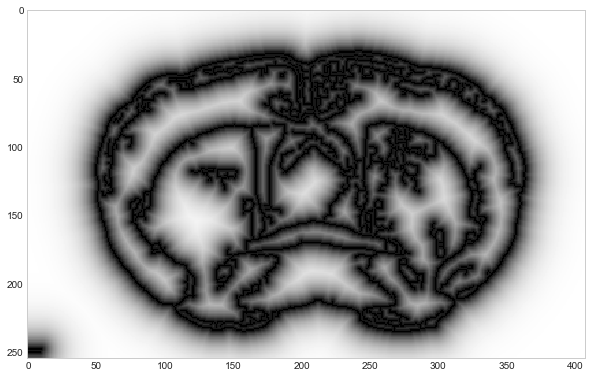

In [59]:
plot_image(dist_epf)

In [60]:
# rotations = [i*2*np.pi/12 for i in range(12)]
rotations = [0] # For testing
# translations_x = [int(outer_edge_down.shape[1]*i/4) for i in range(4)] # Horizontal translatins
# translations_y = [int(outer_edge_down.shape[0]*i/4) for i in range(4)] # Vertical translations
translations_x = [0]
translations_y = [0]
scales = [0.8, 0.9, 1.0]
threshold = 0.2

In [61]:
medium_res = {}
for cp in coarse_pixels:
    for ty in translations_y:
        for tx in translations_x:
            for s in scales:
                for r in rotations:
                    # resize the template
                    outer_edge_down_rz = cv2.resize(outer_edge_down,None,fx=s*cp[-2], fy=s*cp[-2], interpolation = cv2.INTER_CUBIC)
                    angle_epf_template = find_angle_epf(outer_edge_down_rz)
                    EPF = 0.0
                    for x in range(outer_edge_down_rz.shape[0]):
                        for y in range(outer_edge_down_rz.shape[1]):
                            # Calculate the modified EPF and store the results in a dictionary
                            EPF += 1 + (dist_epf[cp[0] + x + tx + cp[2], cp[1] + y + ty + cp[3]])*np.absolute(np.cos(angle_epf[cp[0] + x + tx + cp[2], cp[1] + y + ty + cp[3]] - angle_epf_template[x, y]))
                    EPF = EPF/(outer_edge_down_rz.shape[0]*outer_edge_down_rz.shape[1])
                    medium_res[(cp[0], cp[1], tx + cp[2], ty + cp[3], s*cp[-2], r)] = EPF
                    print("pixel: {}, scale: {}, EPF: {}".format(cp, s*cp[-2], EPF))

pixel: (26, 56, 0, 0, 0.9, 0), scale: 0.7200000000000001, EPF: 0.5025400263510817
pixel: (26, 56, 0, 0, 0.9, 0), scale: 0.81, EPF: 0.5072989276265645
pixel: (26, 56, 0, 0, 0.9, 0), scale: 0.9, EPF: 0.4997036759090502
pixel: (26, 57, 0, 0, 0.9, 0), scale: 0.7200000000000001, EPF: 0.5019232296674399
pixel: (26, 57, 0, 0, 0.9, 0), scale: 0.81, EPF: 0.5072753941863815
pixel: (26, 57, 0, 0, 0.9, 0), scale: 0.9, EPF: 0.49952452096376443
pixel: (29, 57, 0, 0, 0.9, 0), scale: 0.7200000000000001, EPF: 0.4990517421178593
pixel: (29, 57, 0, 0, 0.9, 0), scale: 0.81, EPF: 0.501734480940773
pixel: (29, 57, 0, 0, 0.9, 0), scale: 0.9, EPF: 0.4955250727186377
pixel: (29, 58, 0, 0, 0.9, 0), scale: 0.7200000000000001, EPF: 0.4985157390663045
pixel: (29, 58, 0, 0, 0.9, 0), scale: 0.81, EPF: 0.5017734617215016
pixel: (29, 58, 0, 0, 0.9, 0), scale: 0.9, EPF: 0.49532344226087294
pixel: (30, 57, 0, 0, 0.9, 0), scale: 0.7200000000000001, EPF: 0.49909022979453627
pixel: (30, 57, 0, 0, 0.9, 0), scale: 0.81, EPF:

In [62]:
maxm = 1.0
for k,v in medium_res.items():
    if v < maxm:
        param = k
        maxm = v

In [63]:
param

(31, 59, 0, 0, 0.9, 0)

In [64]:
# Check fit
h, w = outer_edge_down.shape
test = cv2.resize(outer_edge_down,(int(0.9*w), int(0.9*h)), interpolation = cv2.INTER_AREA)

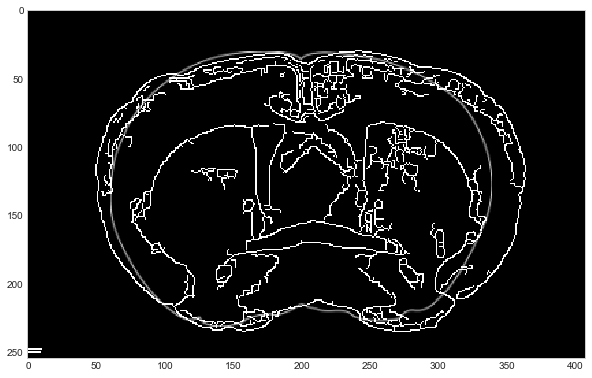

In [65]:
mask = np.zeros_like(edges)
mask[31:31+test.shape[0], 61:61+test.shape[1]] = test
out = edges | mask
plot_image(out)

## Stage 3: Template Warping

### Particle Swarm Optimization

In [66]:
# Accepts a point, the base image's diagonal length, & base image pixels
def energy_penalty():
    

class Particle:
    def __init__(self, point, radius):
        # Finding a random point within radius of control point
        u, v = np.random.random_sample(2)
        w = radius * np.sqrt(u)
        t = 2*np.pi*v
        x = int(w * np.cos(t))
        y = int(w * np.sin(t))
        
        self.pos = [x+point[0], y+point[1]]
        self.personal_best = self.pos
        self.global_best = self.pos
        self.v = [0,0] # or -1,1
        
def update_swarm(swarm):
    best = []
    for particle in swarm:
        if energy_penalty(particle.pos) < energy_penalty(particle.personal_best):
            particle.personal_best = particle.pos
        if energy_penalty(particle.pos) < energy_penalty(particle.global_best):
            best

IndentationError: expected an indented block (<ipython-input-66-e37f4e75840a>, line 5)

In [ ]:
template_controls = [[53,70], [80,80], [92,30]]
swarms = []
for point in template_controls:
    swarm = []
    for i in range(0,10): # However many particles we want
        agent = Particle(point, 30)
        print(agent.pos)
        swarm.append(agent)
    swarms.append(swarm)